In [31]:
import pandas as pd
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


# Step 1: Merge Data

In [1]:


# Paths to the files are given by the user
calendar_files = {
    '2022_09': '2022_09_calendar.csv',
    '2022_12': '2022_12_calendar.csv',
    '2023_03': '2023_03_calendar.csv',
    '2023_06': '2023_06_calendar.csv',
    '2023_09': '2023_09_calendar.csv',
}

listings_files = {
    '2022_09': '2022_09_listings.csv',
    '2022_12': '2022_12_listings.csv',
    '2023_03': '2023_03_listings.csv',
    '2023_06': '2023_06_listings.csv',
    '2023_09': '2023_09_listings.csv',
}

# Initialize an empty DataFrame to hold the merged data
merged_data = pd.DataFrame()

for period in calendar_files:
    calendar_path = calendar_files[period]
    listings_path = listings_files[period]

    # Read the calendar and listings data
    calendar_df = pd.read_csv(calendar_path)
    listings_df = pd.read_csv(listings_path)

    # Convert 'date' in calendar_df to datetime and ensure IDs are of the same type
    calendar_df['date'] = pd.to_datetime(calendar_df['date']).dt.date
    calendar_df['listing_id'] = calendar_df['listing_id'].astype(str)
    listings_df['id'] = listings_df['id'].astype(str)

    # Create a 'price_listing' column in listings data
    listings_df['price_listing'] = listings_df['price']
    listings_df['minimum_nights_listing'] = listings_df['minimum_nights']
    listings_df['maximum_nights_listing'] = listings_df['maximum_nights']

    # Keep only necessary columns from calendar and listings data
    calendar_df = calendar_df[['listing_id', 'date', 'available', 'price', 'minimum_nights', 'maximum_nights']]
    listings_columns_to_keep = [
        'id',  # Unique identifier for the listing
        'price_listing',  # Assuming this is the target variable: price
        'minimum_nights_listing',  # Minimum nights required to book
        'maximum_nights_listing',  # Maximum nights available to book
        'host_since',  # Date when the host started on Airbnb
        'host_verifications',  # Types of host verification
        'host_acceptance_rate',  # Rate at which the host accepts booking requests
        'host_is_superhost',  # Whether the host has Superhost status
        'neighbourhood_cleansed',  # Normalized location information
        'property_type',  # Type of property being offered
        'room_type',  # Type of room being offered
        'accommodates',  # Number of guests the listing can accommodate
        'bathrooms_text',  # Description of bathrooms available
        'bedrooms',  # Number of bedrooms included in the listing
        'beds',  # Number of beds included in the listing
        'amenities',  # Amenities offered with the listing
        'license',  # The license or registration number
        'number_of_reviews',  # Total number of reviews
        'number_of_reviews_l30d',  # Number of reviews in the last 30 days
        'review_scores_rating',  # Overall rating score given by reviewers
        'availability_30',  # Availability over the next 30 days
        'availability_60',  # Availability over the next 60 days
        'availability_90',  # Availability over the next 90 days
        'availability_365',  # Availability over the next 365 days
        'instant_bookable',  # Indicates if the listing can be booked instantly
        'calculated_host_listings_count',  # Number of listings the host has in total
        'host_response_time',  # Average time the host takes to respond to messages
        'host_response_rate',  # Percentage of messages the host responds to
        'host_listings_count',  # Number of listings a host manages (from my original list)
        'host_identity_verified',  # Whether the host's identity has been verified (from my original list)
        'review_scores_accuracy',  # Accuracy of the listing description as rated by reviewers (from my original list)
        'review_scores_cleanliness',  # Cleanliness score as rated by reviewers (from my original list)
        'review_scores_checkin',  # Check-in experience score as rated by reviewers (from my original list)
        'review_scores_communication',  # Communication score as rated by reviewers (from my original list)
        'review_scores_location',  # Location score as rated by reviewers (from my original list)
        'review_scores_value',  # Value score as rated by reviewers (from my original list)
        'reviews_per_month'  # Average number of reviews per month (from my original list)
    ]

    listings_df = listings_df[listings_columns_to_keep]

    # Find missing IDs and their date range
    missing_ids = set(listings_df['id']) - set(calendar_df['listing_id'])
    date_range = pd.date_range(start=calendar_df['date'].min(), end=calendar_df['date'].max())

    # For each missing ID, create new rows
    for missing_id in missing_ids:
        listing_details = listings_df[listings_df['id'] == missing_id]
        missing_rows = pd.DataFrame({
            'listing_id': missing_id,
            'date': date_range,
            'available': 'f',
            'price': listing_details['price_listing'].values[0],
            'minimum_nights': listing_details['minimum_nights_listing'].values[0],
            'maximum_nights': listing_details['maximum_nights_listing'].values[0]
        })
        calendar_df = pd.concat([calendar_df, missing_rows], ignore_index=True)

 # Merge calendar data with the corresponding listings data
    period_merged_data = calendar_df.merge(listings_df, how='left', left_on='listing_id', right_on='id')

 # Append the period data to the full merged dataset
    merged_data = pd.concat([merged_data, period_merged_data], ignore_index=True)

# Drop duplicates, if any
merged_data.drop_duplicates(subset=['listing_id', 'date'], keep='last', inplace=True)

# Handle missing values
merged_data.fillna(method='ffill', inplace=True)

# Save the cleaned, merged data to a new CSV file
output_file = 'merged_cleaned_data.csv'
merged_data.to_csv(output_file, index=False)

print(f"Processed data saved to {output_file}")

c:\Users\yirsu\.conda\envs\Bark\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\yirsu\.conda\envs\Bark\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\yirsu\.conda\envs\Bark\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


Processed data saved to merged_cleaned_data.csv


# Step 2: Data Cleaning Procedures

In [7]:
# Load the dataset
file_path = 'merged_cleaned_data.csv'  # Replace with your actual file path
data = pd.read_csv(file_path)

# Convert 't' and 'f' to 1 and 0
for col in data.columns:
    unique_values = data[col].dropna().unique()
    if set(unique_values) == {'t', 'f'}:
        data[col] = data[col].map({'t': 1, 'f': 0})

# Convert 'bathrooms_text' to numerical
data['bathrooms'] = data['bathrooms_text'].str.extract('(\d+)').astype(float)

# Count the number of amenities and add as a new column
data['amenities_count'] = data['amenities'].str.count(',') + 1

# Drop the original 'bathrooms_text' and 'amenities' columns
data.drop(columns=['bathrooms_text', 'amenities'], inplace=True)

# Convert specific columns to binary (0 or 1)
data['license'] = data['license'].notna().astype(int)

# Classify columns
numerical_cols = []
categorical_cols = []
date_cols = []

# Functions to detect datetime and numeric columns
def is_datetime(col):
    try:
        pd.to_datetime(data[col], errors='raise')
        return True
    except ValueError:
        return False

def is_numeric(col):
    temp_col = data[col].replace('[%\$€£₹¥,;:]', '', regex=True)
    temp_col = pd.to_numeric(temp_col, errors='coerce')
    return pd.notnull(temp_col).any()

# Iterate over columns and classify them
for col in data.columns:
    if data[col].dtype == 'object':
        if is_datetime(col):
            date_cols.append(col)
            data[col] = pd.to_datetime(data[col], errors='coerce')
        elif is_numeric(col):
            data[col] = data[col].replace('[%\$€£₹¥,;:]', '', regex=True)
            data[col] = pd.to_numeric(data[col], errors='coerce')
            numerical_cols.append(col)
        else:
            categorical_cols.append(col)
    elif data[col].dtype in ['int64', 'float64']:
        numerical_cols.append(col)
    else:
        categorical_cols.append(col)


# # Replace spaces with underscores in categorical column names
# for col in categorical_cols:
#     data.rename(columns={col: col.replace(' ', '_')}, inplace=True)
# # Apply One-hot encode categorical columns+
# data = pd.get_dummies(data, columns=categorical_cols)

# Apply Binary Encoding to categorical columns
encoder = ce.BinaryEncoder(cols=categorical_cols)
data_encoded = encoder.fit_transform(data[categorical_cols])

# Concatenate the encoded columns with the original data, excluding original categorical columns
data = pd.concat([data.drop(categorical_cols, axis=1), data_encoded], axis=1)

# Output the updated DataFrame structure
print(data.info())

# Save the cleaned data
cleaned_data_path = 'cleaned_merged_data.csv'
data.to_csv(cleaned_data_path, index=False)

# Output the column types
print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)
print("Date columns:", date_cols)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3864359 entries, 0 to 3864358
Data columns (total 59 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   listing_id                      int64         
 1   date                            datetime64[ns]
 2   available                       int64         
 3   price                           float64       
 4   minimum_nights                  float64       
 5   maximum_nights                  float64       
 6   id                              int64         
 7   price_listing                   float64       
 8   minimum_nights_listing          int64         
 9   maximum_nights_listing          int64         
 10  host_since                      datetime64[ns]
 11  host_acceptance_rate            int64         
 12  host_is_superhost               int64         
 13  accommodates                    int64         
 14  bedrooms                        float64       
 15

In [41]:
# Testing: Load your data
data = pd.read_csv('cleaned_merged_data.csv')  # Replace with the actual path to your data

# Check for missing values
missing_values = data.isna().sum()

# Print the count of missing values in each column
print(missing_values)

# To check if there are any missing values in the DataFrame at all
any_missing = data.isna().any().any()
print("Are there any missing values in the DataFrame? ", any_missing)

listing_id                           0
date                                 0
available                            0
price                                0
minimum_nights                       0
maximum_nights                       0
id                                   0
price_listing                        0
minimum_nights_listing               0
maximum_nights_listing               0
host_since                           0
host_acceptance_rate                 0
host_is_superhost                    0
accommodates                         0
bedrooms                             0
beds                                 0
number_of_reviews                    0
number_of_reviews_l30d               0
review_scores_rating                 0
availability_30                      0
availability_60                      0
availability_90                      0
availability_365                     0
instant_bookable                     0
calculated_host_listings_count       0
host_response_rate       

In [42]:
# Display rows where 'bathrooms' is missing
missing_bathrooms_data = data[data['bathrooms'].isna()]
print(missing_bathrooms_data.head())  # Display the first few rows

# Statistical summary of the 'bathrooms' column
print("\nStatistical Summary of 'bathrooms':")
print(data['bathrooms'].describe())

       listing_id        date  available  price  minimum_nights  \
21839    13082258  2022-09-15          0   52.0            91.0   
21840    13082258  2022-09-16          0   52.0            91.0   
21841    13082258  2022-09-17          0   52.0            91.0   
21842    13082258  2022-09-18          0   52.0            91.0   
21843    13082258  2022-09-19          0   52.0            91.0   

       maximum_nights        id  price_listing  minimum_nights_listing  \
21839          1125.0  13082258           52.0                      91   
21840          1125.0  13082258           52.0                      91   
21841          1125.0  13082258           52.0                      91   
21842          1125.0  13082258           52.0                      91   
21843          1125.0  13082258           52.0                      91   

       maximum_nights_listing  ... property_type_4  property_type_5  \
21839                    1125  ...               1                1   
21840     

In [43]:
# Fill missing values in 'bathrooms' with 0
data['bathrooms'].fillna(0, inplace=True)

# Optionally, check if there are any remaining missing values in 'bathrooms'
missing_bathrooms = data['bathrooms'].isna().sum()
print("Missing values in bathrooms after filling:", missing_bathrooms)

# Save the updated data
updated_data_path = 'updated_merged_data.csv'
data.to_csv(updated_data_path, index=False)

Missing values in bathrooms after filling: 0


In [21]:
# Generate a summary table with two decimal points
summary_table = data.describe(include='all').applymap(lambda x: round(x, 2) if isinstance(x, float) else x)

print(summary_table)

          listing_id        date   available       price  minimum_nights  \
count   3.864359e+06     3864359  3864359.00  3864359.00      3864359.00   
unique           NaN         731         NaN         NaN             NaN   
top              NaN  2023-08-29         NaN         NaN             NaN   
freq             NaN        6698         NaN         NaN             NaN   
mean    2.614182e+17         NaN        0.52      237.77           65.09   
std     3.576345e+17         NaN        0.50      349.53          134.89   
min     3.168000e+03         NaN        0.00        0.00            1.00   
25%     2.541631e+07         NaN        0.00       98.00            2.00   
50%     4.860119e+07         NaN        1.00      174.00           21.00   
75%     6.522855e+17         NaN        1.00      278.00           91.00   
max     9.804836e+17         NaN        1.00    15300.00          998.00   

        maximum_nights            id  price_listing  minimum_nights_listing  \
count   

C:\Users\yirsu\AppData\Local\Temp\ipykernel_18688\3583007989.py:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=data[data['available'] == 1], x='date', y='price', label='Treatment', ci=None)
C:\Users\yirsu\AppData\Local\Temp\ipykernel_18688\3583007989.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=data[data['available'] == 0], x='date', y='price', label='Control', ci=None)


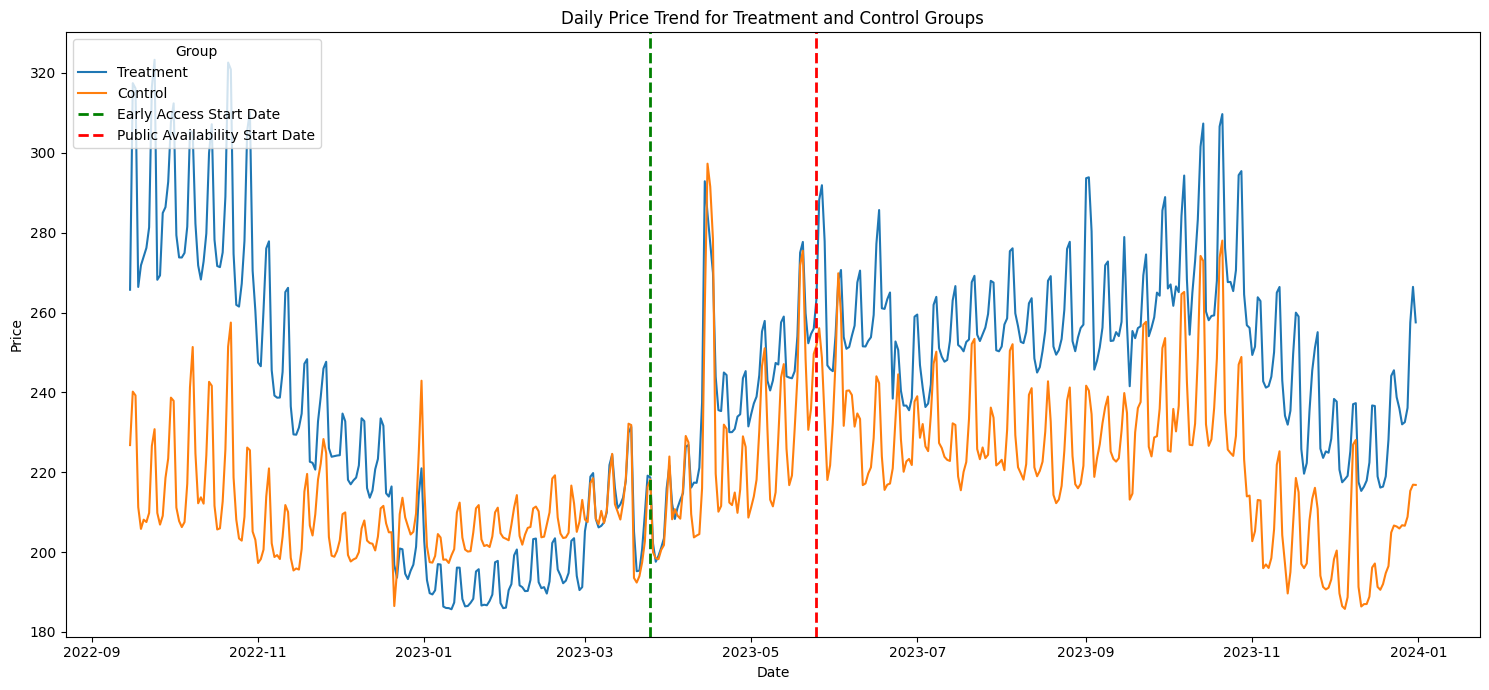

In [44]:
# Convert date to datetime
data['date'] = pd.to_datetime(data['date'])

# Define the date range for plotting
start_date = '2022-09-01'  # Start of your data
end_date = '2023-12-31'  # End of the date range you want to plo

# Filter data for the date range
data = data[(data['date'] >= start_date) & (data['date'] <= end_date)]

# Define cutoff dates for the introduction of the Smart Pricing tool
early_access_start = pd.to_datetime('2023-03-25')
public_availability_start = pd.to_datetime('2023-05-25')

# Create a binary variable for post-policy based on the early_access_start date
data['post_policy'] = (data['date'] >= early_access_start).astype(int)

# Plotting
plt.figure(figsize=(15, 7))

# Treatment group plot
sns.lineplot(data=data[data['available'] == 1], x='date', y='price', label='Treatment', ci=None)

# Control group plot
sns.lineplot(data=data[data['available'] == 0], x='date', y='price', label='Control', ci=None)

# Highlight the policy change dates
plt.axvline(x=pd.to_datetime('2023-03-25'), color='green', linestyle='--', lw=2, label='Early Access Start Date')
plt.axvline(x=pd.to_datetime('2023-05-25'), color='red', linestyle='--', lw=2, label='Public Availability Start Date')

# Improve the legend
plt.legend(title='Group', loc='upper left')

# Title and labels
plt.title('Daily Price Trend for Treatment and Control Groups')
plt.xlabel('Date')
plt.ylabel('Price')

# Tight layout for saving
plt.tight_layout()

# Show plot
plt.show()

C:\Users\yirsu\AppData\Local\Temp\ipykernel_18688\17478203.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=data[data['available'] == 1], x='date', y='price_smoothed', label='Treatment', ci=None)
C:\Users\yirsu\AppData\Local\Temp\ipykernel_18688\17478203.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=data[data['available'] == 0], x='date', y='price_smoothed', label='Control', ci=None)


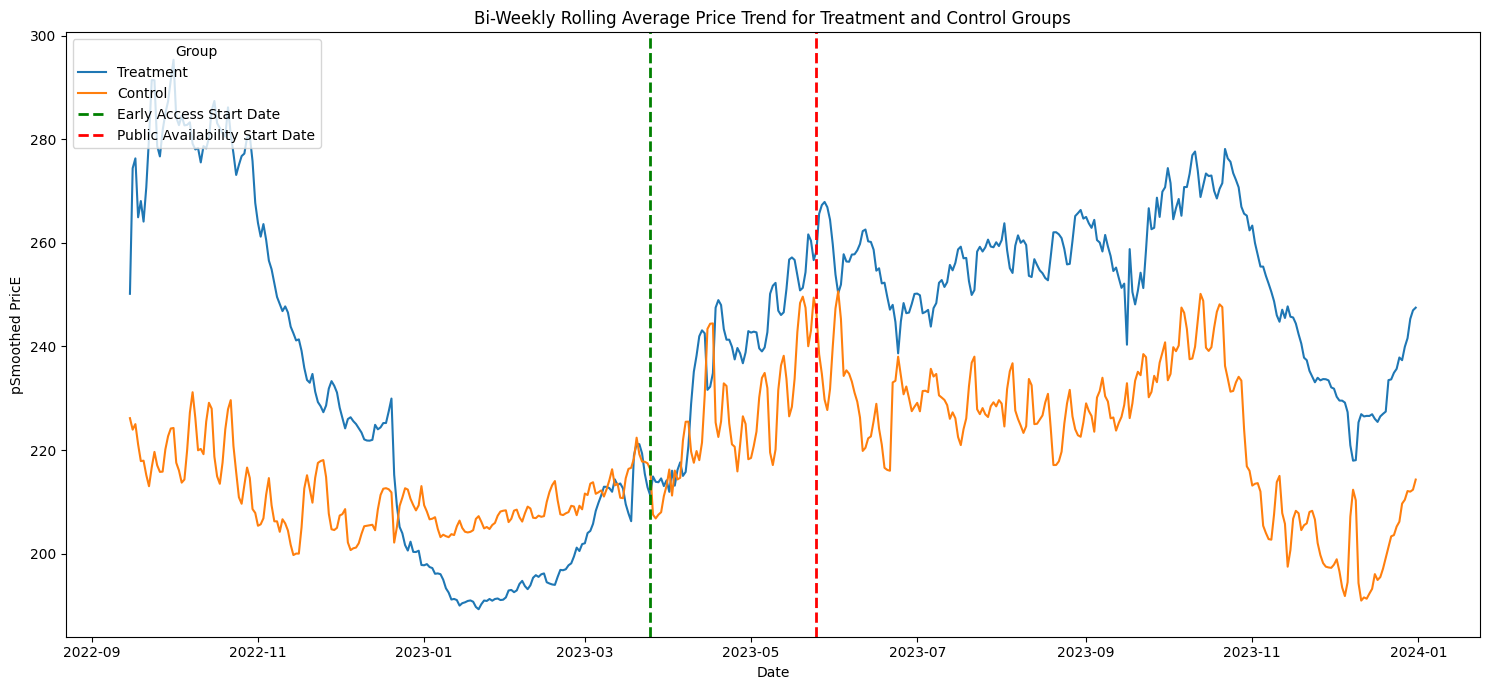

In [45]:
data['price_smoothed'] = data.groupby('available')['price'].transform(lambda x: x.rolling(14, center=True).mean())

# Plotting
plt.figure(figsize=(15, 7))

# Treatment group plot
sns.lineplot(data=data[data['available'] == 1], x='date', y='price_smoothed', label='Treatment', ci=None)

# Control group plot
sns.lineplot(data=data[data['available'] == 0], x='date', y='price_smoothed', label='Control', ci=None)

# Highlight the policy change dates
plt.axvline(x=pd.to_datetime('2023-03-25'), color='green', linestyle='--', lw=2, label='Early Access Start Date')
plt.axvline(x=pd.to_datetime('2023-05-25'), color='red', linestyle='--', lw=2, label='Public Availability Start Date')

# Improve the legend
plt.legend(title='Group', loc='upper left')

# Title and labels
plt.title('Bi-Weekly Rolling Average Price Trend for Treatment and Control Groups')
plt.xlabel('Date')
plt.ylabel('pSmoothed PricE')

# Tight layout for saving
plt.tight_layout()

# Show plot
plt.show()


### IVs should have the following characteristics:

* Strongly correlated with available_dummy (the treatment variable).
* Not correlated or very weakly correlated with the price (the outcome variable), which is not shown in this correlation matrix but is necessary to check.

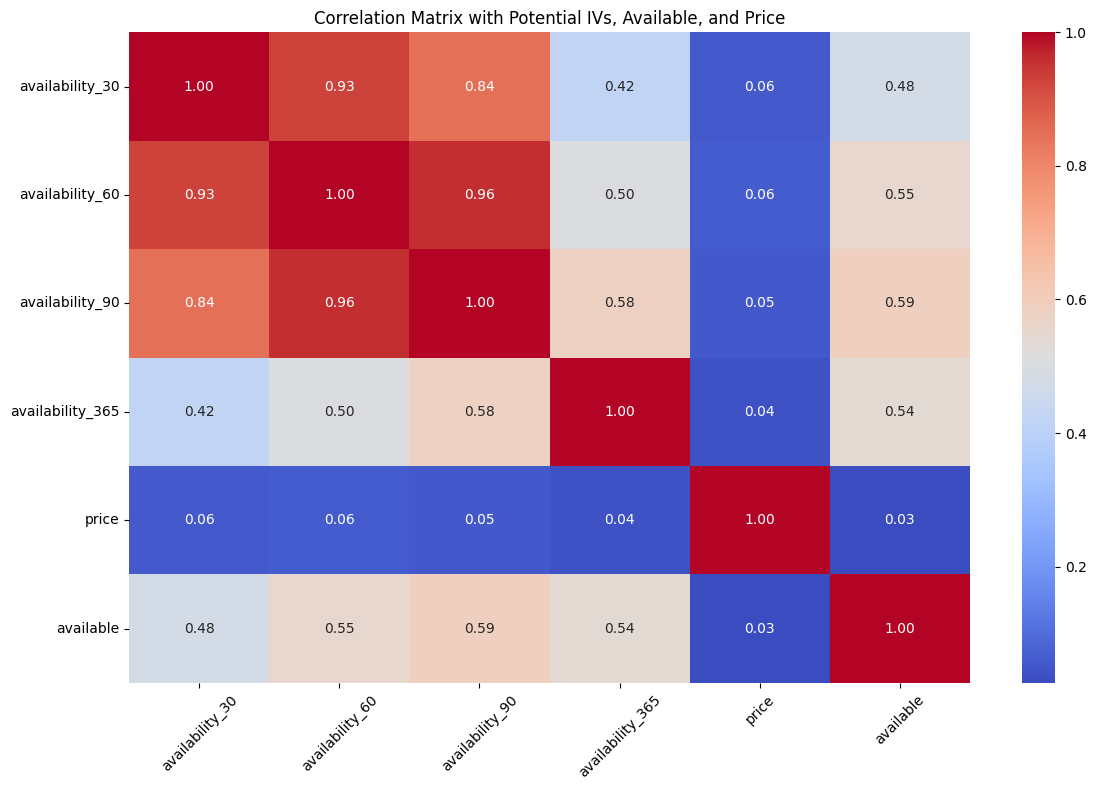

['availability_30', 'availability_60', 'availability_90', 'availability_365']


In [47]:
# Exclude non-relevant variables from the correlation matrix
excluded_vars = ['days_from_cutoff', 'listing_id', 'id', 'price_listing', 'minimum_nights_listing', 
                 'maximum_nights_listing']
all_cols = data.columns.tolist()
relevant_cols = [col for col in all_cols if col not in excluded_vars]

# Calculate the correlation matrix
corr_matrix = data[relevant_cols].corr()

# Define thresholds and identify potential IVs
corr_with_treatment_threshold = 0.2 # Min
corr_with_price_threshold = 0.1 # Max
potential_ivs = [col for col in corr_matrix.columns if (col != 'available') and (abs(corr_matrix.loc[col, 'available']) > corr_with_treatment_threshold) and (abs(corr_matrix.loc[col, 'price']) < corr_with_price_threshold)]

# Plot the final correlation matrix heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix.loc[potential_ivs + ['price', 'available'], potential_ivs + ['price', 'available']], annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix with Potential IVs, Available, and Price")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
print(potential_ivs)

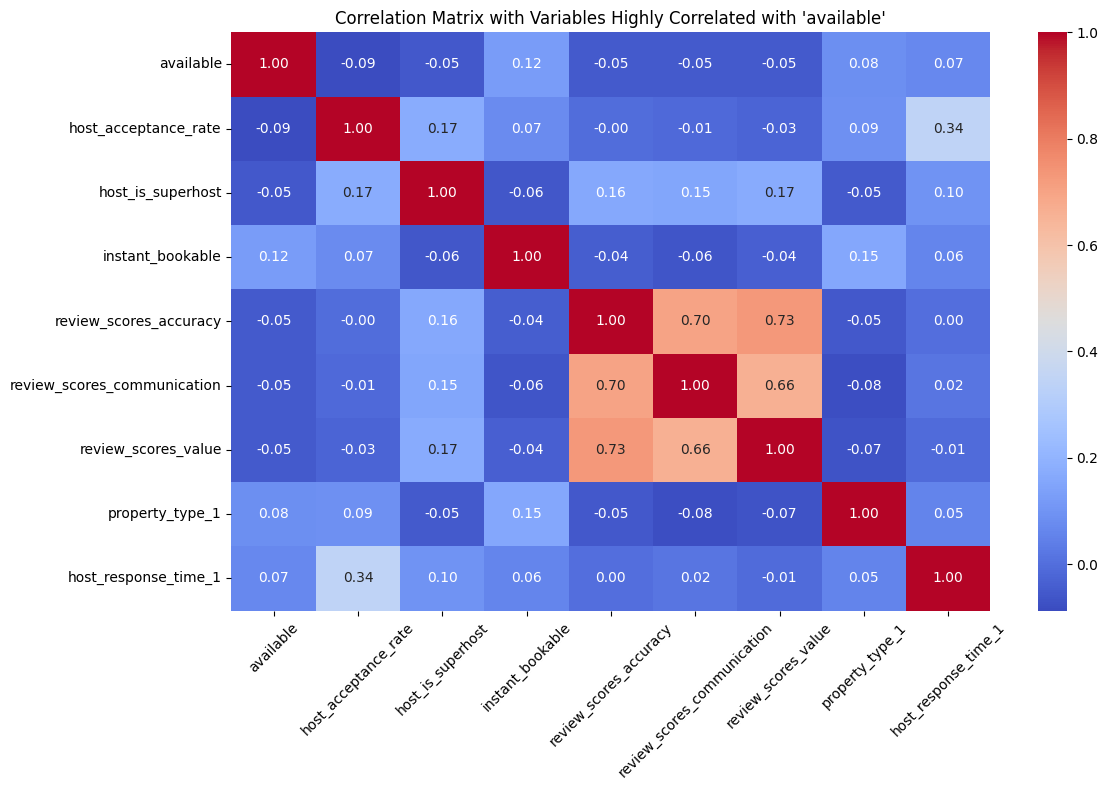

Variables with high correlation to 'available': ['available', 'host_acceptance_rate', 'host_is_superhost', 'instant_bookable', 'review_scores_accuracy', 'review_scores_communication', 'review_scores_value', 'property_type_1', 'host_response_time_1']


In [52]:
excluded_vars = ['days_from_cutoff', 'listing_id', 'id', 'price_listing', 'minimum_nights_listing', 
                 'maximum_nights_listing','price_smoothed']

excluded_vars = excluded_vars + potential_ivs

# Initialize a list to store variables with high correlation
control_vars_1st = []

# Define the correlation threshold
corr_threshold = 0.05

# Calculate correlations for each numeric variable in the DataFrame
for var in data.columns:
    if var in excluded_vars or not pd.api.types.is_numeric_dtype(data[var]):
        continue
    corr_with_available = data['available'].corr(data[var])
    if abs(corr_with_available) >= corr_threshold:
        control_vars_1st.append(var)

# Calculate and plot the final correlation matrix for the selected high correlation variables
final_corr_matrix = data[control_vars_1st].corr()

# Plot the final heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(final_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Correlation Matrix with Variables Highly Correlated with 'available'")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Display the list of variables with high correlation
print("Variables with high correlation to 'available':", control_vars_1st)



In [57]:
control_vars_1st = ['host_acceptance_rate', 'host_is_superhost', 'instant_bookable', 'review_scores_accuracy', 'review_scores_communication', 
                    'review_scores_value', 'host_response_time_0', 'host_response_time_1', 'host_response_time_2']

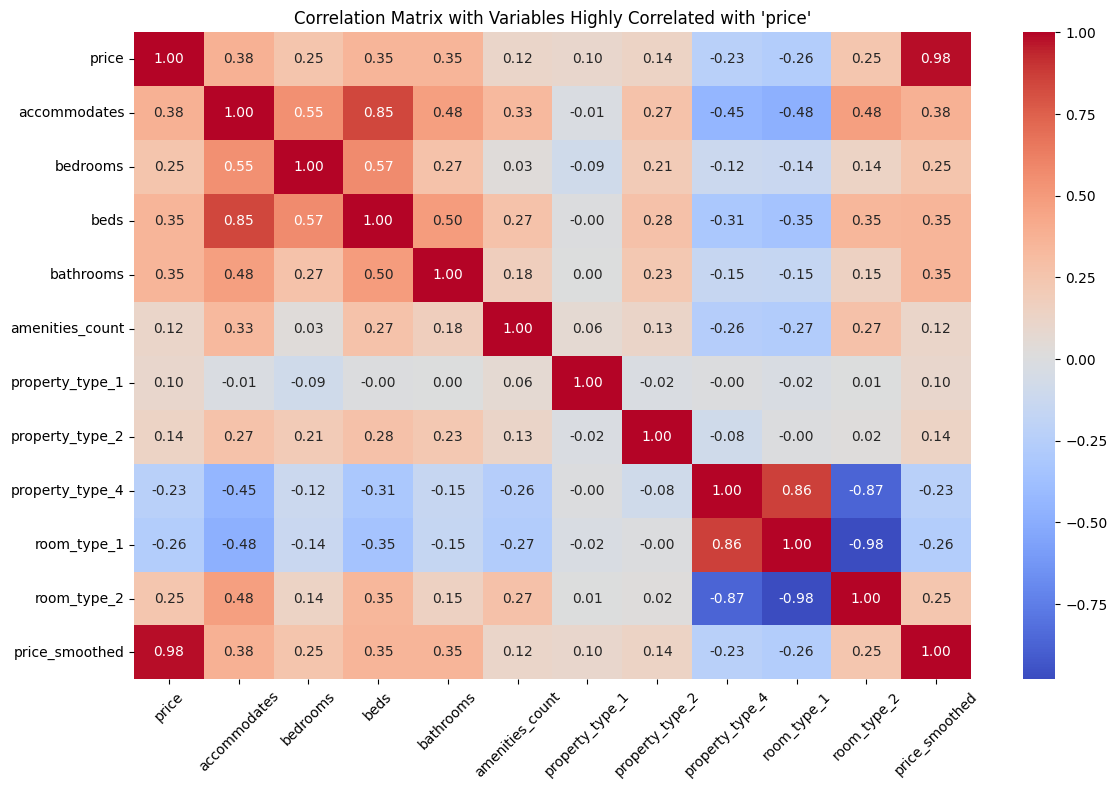

Variables with high correlation to 'price': ['price', 'accommodates', 'bedrooms', 'beds', 'bathrooms', 'amenities_count', 'property_type_1', 'property_type_2', 'property_type_4', 'room_type_1', 'room_type_2', 'price_smoothed']


In [56]:
# Initialize a list to store variables with high correlation
control_vars_2nd = []

# Define the correlation threshold
corr_threshold = 0.10

# Calculate correlations for each numeric variable in the DataFrame
for var in data.columns:
    if var in excluded_vars or not pd.api.types.is_numeric_dtype(data[var]):
        continue
    corr_with_available = data['price'].corr(data[var])
    if abs(corr_with_available) >= corr_threshold:
        control_vars_2nd.append(var)

# Calculate and plot the final correlation matrix for the selected high correlation variables
final_corr_matrix = data[control_vars_2nd].corr()

# Plot the final heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(final_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Correlation Matrix with Variables Highly Correlated with 'price'")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Display the list of variables with high correlation
print("Variables with high correlation to 'price':", control_vars_2nd)

In [61]:
control_vars_2nd = ['accommodates', 'bedrooms', 'beds', 'bathrooms', 'amenities_count', 
                    'property_type_0','property_type_1','property_type_2','property_type_3','property_type_4','property_type_5',
                    'room_type_0','room_type_1','room_type_2']

In [194]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Define cutoff date and create treatment assignment
cutoff_date = pd.to_datetime('2023-03-25')
bandwidth = 30  # Define your bandwidth (e.g., 30 days)

# Restrict data to observations within the bandwidth around the cutoff
data['days_from_cutoff'] = (data['date'] - cutoff_date).dt.days
data_within_bandwidth = data[abs(data['days_from_cutoff']) <= bandwidth]

# Treatment assignment
data_within_bandwidth['treatment_assigned'] = ((data_within_bandwidth['available_dummy'] == 1) & (data_within_bandwidth['date'] >= cutoff_date)).astype(int)

# First Stage: Predict the treatment assignment using potential IVs and control variables
first_stage_vars = ['days_from_cutoff'] + ivs + control_vars_1st
first_stage_formula = 'treatment_assigned ~ 1 + ' + ' + '.join(first_stage_vars)
first_stage_model = smf.ols(formula=first_stage_formula, data=data).fit(cov_type='HC3')
data['predicted_treatment'] = first_stage_model.fittedvalues

# Second Stage: Regress the outcome on the predicted treatment and the control variables
# Ensure control_vars_2nd is defined and properly formatted
second_stage_vars = ['predicted_treatment'] + control_vars_2nd
second_stage_formula = 'price ~ 1 + ' + ' + '.join(second_stage_vars)
second_stage_model = smf.ols(formula=second_stage_formula, data=data).fit(cov_type='HC3')

# Print the summary of the regression results
print(second_stage_model.summary())

C:\Users\yirsu\AppData\Local\Temp\ipykernel_11972\3985732847.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_within_bandwidth['treatment_assigned'] = ((data_within_bandwidth['available_dummy'] == 1) & (data_within_bandwidth['date'] >= cutoff_date)).astype(int)


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                 3.653e+04
Date:                Fri, 15 Dec 2023   Prob (F-statistic):               0.00
Time:                        13:27:28   Log-Likelihood:            -2.7624e+07
No. Observations:             3861716   AIC:                         5.525e+07
Df Residuals:                 3861681   BIC:                         5.525e+07
Df Model:                          34                                         
Covariance Type:                  HC3                                         
                                                     coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

### key findings and conclusions:

1. Predicted Treatment (smart_pricing_tool): The coefficient for predicted_treatment is 77.0888 with a p-value close to 0, indicating a strong and statistically significant positive relationship with price. This suggests that the use of Airbnb's pricing tool (treatment) is associated with a significant increase in listing price.

2. Model Fit: The R-squared value is 0.209, meaning that approximately 20.9% of the variability in the price is explained by the model. This is a moderate level of explanatory power, suggesting that other factors not included in the model also significantly affect price.

3. Intercept: The intercept value of -16.0337 suggests that the baseline price (excluding the effect of all variables) is negative, which may be a sign of overfitting or multicollinearity issues, or it might reflect that certain key variables are missing from the model.

4. Other Variables:

* Accommodates, bedrooms, beds, and bathrooms show significant positive associations with price.
* Amenities count has a small negative association with price.
* Specific neighborhood (neighbourhood_cleansed_Downtown) and property types (like Entire_serviced_apartment, Room_in_hotel) have significant positive effects on price.
* Certain room types (Private_room_in_home, Private_room_in_rental_unit) are associated with lower prices, while Hotel_room significantly increases price.
5. Statistical Significance: All variables in the model are statistically significant, as indicated by their p-values.

6. Model Diagnostics: The Durbin-Watson statistic is close to 2, suggesting no autocorrelation issues. However, the Omnibus and Jarque-Bera tests indicate potential problems with the normality of residuals. The very high skewness and kurtosis values also imply that the residuals are not normally distributed, which is a key assumption of OLS regression. This may affect the reliability of the coefficient estimates and their standard errors.

#### Conclusion: The use of Airbnb’s pricing tool is associated with higher prices for listings. The model also highlights important factors influencing the price, such as accommodation capacity, property type, and location. However, the potential issues with residual normality and the moderate R-squared value suggest that further refinement of the model may be necessary for a more accurate understanding of price determinants in Airbnb listings.

# 1st Stage F test

In [195]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Assuming data and potential_ivs are defined
# Let's assume 'endog_expl_var' is your endogenous explanatory variable

# First Stage: Predict the treatment assignment using potential IVs and control variables
first_stage_vars = ['days_from_cutoff'] + potential_ivs + control_vars_1st
first_stage_formula = 'treatment_assigned ~ 1 + ' + ' + '.join(first_stage_vars)
first_stage_model = smf.ols(formula=first_stage_formula, data=data).fit()
data['predicted_treatment'] = first_stage_model.fittedvalues

# Check the F-statistic
f_statistic = first_stage_model.fvalue
print("First-stage F-statistic:", f_statistic)

# Interpret the F-statistic
if f_statistic < 10:
    print("Warning: Potential weak instruments.")
else:
    print("IVs seem to be strong.")


First-stage F-statistic: 123115.3585351589
IVs seem to be strong.


# Durbin-Wu-Hausman test

In [189]:
# import statsmodels.api as sm

# # Fit the first-stage regression
# first_stage_model = smf.ols(formula="treatment_assigned ~ 1 + days_from_cutoff + " + " + ".join(potential_ivs + control_vars_1st), 
#                            data=data).fit(cov_type="HC3")

# # Extract the fitted values as the predicted treatment
# predicted_treatment = first_stage_model.fittedvalues

# # Fit the second-stage regression
# second_stage_model = smf.ols(formula="price ~ 1 + predicted_treatment + " + " + ".join(control_vars_2nd), data=data).fit(cov_type="HC3")

# # Perform the Durbin-Wu-Hausman test
# dw_test = sm.stats.dwtest(second_stage_model.resid, first_stage_model.fittedvalues)

# # Print the test results
# print("Durbin-Wu-Hausman test statistic:", dw_test.statistic)
# print("p-value:", dw_test.pvalue)

# Robusness Test

## Bandwidth = 100 Days

In [197]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Define cutoff date and create treatment assignment
cutoff_date = pd.to_datetime('2023-03-25')
bandwidth = 100  # Define your bandwidth (e.g., 30 days)

# Restrict data to observations within the bandwidth around the cutoff
data['days_from_cutoff'] = (data['date'] - cutoff_date).dt.days
data_within_bandwidth = data[abs(data['days_from_cutoff']) <= bandwidth]

# Treatment assignment
data_within_bandwidth['treatment_assigned'] = ((data_within_bandwidth['available_dummy'] == 1) & (data_within_bandwidth['date'] >= cutoff_date)).astype(int)

# First Stage: Predict the treatment assignment using potential IVs and control variables
first_stage_vars = ['days_from_cutoff'] + ivs + control_vars_1st
first_stage_formula = 'treatment_assigned ~ 1 + ' + ' + '.join(first_stage_vars)
first_stage_model = smf.ols(formula=first_stage_formula, data=data).fit(cov_type='HC3')
data['predicted_treatment'] = first_stage_model.fittedvalues

# Second Stage: Regress the outcome on the predicted treatment and the control variables
# Ensure control_vars_2nd is defined and properly formatted
second_stage_vars = ['predicted_treatment'] + control_vars_2nd
second_stage_formula = 'price ~ 1 + ' + ' + '.join(second_stage_vars)
second_stage_model = smf.ols(formula=second_stage_formula, data=data).fit(cov_type='HC3')

# Print the summary of the regression results
print(second_stage_model.summary())

C:\Users\yirsu\AppData\Local\Temp\ipykernel_11972\648688090.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_within_bandwidth['treatment_assigned'] = ((data_within_bandwidth['available_dummy'] == 1) & (data_within_bandwidth['date'] >= cutoff_date)).astype(int)


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                 3.653e+04
Date:                Fri, 15 Dec 2023   Prob (F-statistic):               0.00
Time:                        13:29:56   Log-Likelihood:            -2.7624e+07
No. Observations:             3861716   AIC:                         5.525e+07
Df Residuals:                 3861681   BIC:                         5.525e+07
Df Model:                          34                                         
Covariance Type:                  HC3                                         
                                                     coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

## Bandwidth = 7 Days

In [198]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Define cutoff date and create treatment assignment
cutoff_date = pd.to_datetime('2023-03-25')
bandwidth = 7  # Define your bandwidth (e.g., 30 days)

# Restrict data to observations within the bandwidth around the cutoff
data['days_from_cutoff'] = (data['date'] - cutoff_date).dt.days
data_within_bandwidth = data[abs(data['days_from_cutoff']) <= bandwidth]

# Treatment assignment
data_within_bandwidth['treatment_assigned'] = ((data_within_bandwidth['available_dummy'] == 1) & (data_within_bandwidth['date'] >= cutoff_date)).astype(int)

# First Stage: Predict the treatment assignment using potential IVs and control variables
first_stage_vars = ['days_from_cutoff'] + ivs + control_vars_1st
first_stage_formula = 'treatment_assigned ~ 1 + ' + ' + '.join(first_stage_vars)
first_stage_model = smf.ols(formula=first_stage_formula, data=data).fit(cov_type='HC3')
data['predicted_treatment'] = first_stage_model.fittedvalues

# Second Stage: Regress the outcome on the predicted treatment and the control variables
# Ensure control_vars_2nd is defined and properly formatted
second_stage_vars = ['predicted_treatment'] + control_vars_2nd
second_stage_formula = 'price ~ 1 + ' + ' + '.join(second_stage_vars)
second_stage_model = smf.ols(formula=second_stage_formula, data=data).fit(cov_type='HC3')

# Print the summary of the regression results
print(second_stage_model.summary())

C:\Users\yirsu\AppData\Local\Temp\ipykernel_11972\3753857701.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_within_bandwidth['treatment_assigned'] = ((data_within_bandwidth['available_dummy'] == 1) & (data_within_bandwidth['date'] >= cutoff_date)).astype(int)


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                 3.653e+04
Date:                Fri, 15 Dec 2023   Prob (F-statistic):               0.00
Time:                        13:30:24   Log-Likelihood:            -2.7624e+07
No. Observations:             3861716   AIC:                         5.525e+07
Df Residuals:                 3861681   BIC:                         5.525e+07
Df Model:                          34                                         
Covariance Type:                  HC3                                         
                                                     coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------